In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display, Math
import logging

for h in logging.getLogger().handlers:
    h.setFormatter(logging.Formatter("[%(levelname)s] %(message)s"))

# Benchmarking an algorithm used to solve a MAX-k-SAT problem

In this notebook we showcase functionality of qubrabench by implementing and benchmarking a hillclimbing algorithm to solve MAX-k-SAT, as described in https://arxiv.org/abs/2203.04975.
<!-- The paper describes two distinct variants of implementing the hillclimber: a simple hillclimber - which uses (quantum) search, and a steep one - which uses (quantum) max finding. -->

## Problem: MAX-k-SAT

Max-k-SAT is a combinatorial optimization problem that given a list of clauses $(C_{i})^{p}_{i=1}$, each a disjunction of at most $k$ literals, and a set of weights $(w_{i})^{p}_{i=1}$, asks us to maximize the weight of the satisfied clauses,
$$\varphi(x) := \sum ^{p} _{i=1} w_{i}C_{i}(x),$$
over all assignments $x \in \{0, 1\}^{q}$ of the variables. This problem is known to be NP-hard for $k ≥ 2$.

In [ ]:
from typing import Sequence
from dataclasses import dataclass


@dataclass
class Clause:
    terms: Sequence[int]
    weight: int

    def is_satisfied(self, assignment: Sequence[bool]) -> bool:
        return all(assignment[abs(x) - 1] == (x > 0) for x in self.terms)


@dataclass
class Instance:
    n_var: int
    clauses: Sequence[Clause]

    def evaluate_weight_of_assignment(self, assignment: Sequence[bool]) -> int:
        """compute \varphi(assignment)"""
        return sum(
            clause.weight for clause in self.clauses if clause.is_satisfied(assignment)
        )

### Example Instance

Consider the following instance for MAX-3-SAT, with 4 variables $x = (x_{1}, x_{2}, x_{3}, x_{4})$: 

$$(\neg x_{1} \lor \neg x_{2} \lor x_{3})_{3} \land (x_{1} \lor x_{2} \lor \neg x_{4})_{5} \land (\neg x_{1} \lor \neg x_{2} \lor x_{4})_{1}$$

In the course of the following sections, we will build an algorithm for MAX-$k$-SAT and use this instance to demonstrate how it works.

In [ ]:
demo_inst = Instance(
    n_var=4,
    clauses=[
        Clause(terms=[-1, -2, 3], weight=3),
        Clause(terms=[1, 2, -4], weight=5),
        Clause(terms=[-1, -2, 4], weight=1),
    ],
)

In this representation, we store the index $i$ for each variable $x_i$ in the clause. A negated literal $\neg x_i$ is stored as $-i$.

We can evaluate $\varphi(x)$ for a given $x$ as follows:

In [ ]:
print(demo_inst.evaluate_weight_of_assignment((1, 1, 0, 0)))

5


## Algorithm: Hillclimber

<!-- A known algorithm to solve this problem is the hillclimber algorithm, which we will be implementing in this notebook. -->
We start with a random assignment $x \in \{0, 1\}^{n}$.
We then repeatedly look for improvements (higher values) of $\varphi$ in the _neighbourhood_ $N(x)$ of the current assignment $x$, and pick one if it exists (i.e. set $x$ to the chosen neighbour, and repeat).
Here, $N(x)$ is the set of all assignments that differ from $x$ in exactly one bit.

We can have different variants of the hillclimber based on how we pick a _better_ neighbour.
In this notebook, we discuss the **steep** hillclimber: pick the neighbour $y$ with the highest value of $\varphi(y)$.
$$x' = \arg\max_{y \in N(x)}(\varphi(y))$$
If $\varphi(x') > \varphi(x)$, we set $x \leftarrow x'$ and repeat, otherwise we stop.

<!-- ## Solving our problem instance

As mentioned above, we can use a hillclimber algorithm to solve the MAX-k-SAT problem. For the purpose of simplicity within this notebook, we will be focussing on the steep hillclimber. Side note: This repository also contains a [hillclimber algorithm](https://github.com/qubrabench/qubrabench/blob/notebooks/examples/sat/bench_hillclimber.py), which uses a more advanced approach and has much better performance than our approach. However, as we are focussing on the functionality of qubrabench in this notebook, this more complex implementation will not be covered in more detail.
 -->
 <!-- 
We will assume, that $d=1$, which enables us to simplify some of our functions. This means, when we look at the neighbourhood of a given variable assignment $y$, we will always be looking at assignments $z\in N_{1}(y)$, that differ from our current assignment in exactly one place. -->

To get our starting assignment, we implement a function which randomly generates a sequence of zeros and ones. 

In [ ]:
def generate_random_assignment(n_var: int, *, rng=np.random.default_rng(42)):
    return tuple(rng.choice((0, 1), size=n_var))


random_assignment = generate_random_assignment(demo_inst.n_var)
print(f"Random assignment: {random_assignment}, which means:")

Math(
    ", ".join(
        f"x_{i + 1} = {random_assignment[i]}" for i, x_i in enumerate(random_assignment)
    )
)

Random assignment: (0, 1, 1, 0), which means:


<IPython.core.display.Math object>

We now need to compute the neighbourhood set $N(x)$ for a given assignment $x$.

In [ ]:
def get_neighbours(x):
    neighbours = []
    for i, x_i in enumerate(x):
        y = list(x)
        y[i] = 1 - x_i
        neighbours.append(tuple(y))
    return neighbours


print(get_neighbours((0, 0, 0, 0)))

[(1, 0, 0, 0), (0, 1, 0, 0), (0, 0, 1, 0), (0, 0, 0, 1)]


We can now pick the _best_ neighbour for a given assignment $x$:

In [ ]:
def find_best_neighbour(x: Sequence[bool], inst: Instance):
    return max(
        get_neighbours(x),
        key=inst.evaluate_weight_of_assignment,
    )


best_neighbour = find_best_neighbour((0, 0, 0, 0), demo_inst)
neighbour_weight = demo_inst.evaluate_weight_of_assignment(best_neighbour)

print(f"Best neighbour: {best_neighbour}, weight = {neighbour_weight}")

Best neighbour: (0, 0, 1, 0), weight = 3


With the above subroutines defined, we can now implement the hillclimber algorithm.

In [ ]:
def hill_climber_sat(
    inst: Instance,
    *,
    rng=np.random.default_rng(42),
):
    # starting assignment
    x = generate_random_assignment(inst.n_var, rng=rng)
    weight = inst.evaluate_weight_of_assignment(x)
    logging.info(f"Starting with assignment: {x}, with weight {weight}")

    while True:
        x_new = find_best_neighbour(x, inst)
        neighbour_weight = inst.evaluate_weight_of_assignment(x_new)
        if neighbour_weight > weight:
            x, weight = x_new, neighbour_weight
            logging.info(f"Found better neighbour: {x}, with weight {weight}")
        else:
            break

    logging.info(f"Completed. Optimal assignment: {x}. Weight: {weight}")
    return x


logging.getLogger().setLevel(logging.INFO)
hill_climber_sat(demo_inst)

[INFO] Starting with assignment: (0, 1, 1, 0), with weight 0
[INFO] Found better neighbour: (1, 1, 1, 0), with weight 5
[INFO] Completed. Optimal assignment: (1, 1, 1, 0). Weight: 5


(1, 1, 1, 0)

## Spotting a pattern: Max

If we take another look at this approach, we will notice, that we calculate the maximum value of a set of numbers within the find_better_assignment function. In this case the maximum weight amongst the weights of all neighbours using the Python max function. 

As it happens there is also a very well known max function, which runs on quantum computers, as described in the paper mentioned in the introduction. With this in mind, the question naturally occurs, what would happen if we ran the computation of max on a quantum machine using this quantum max function and if this would have any performance improvements.

This library offers a function, which enables a user to simulate doing exactly this and to keep track of runtime stats and approximations for quantum call counts, if the quantum max function was used and run on a quantum machine.

## Max Function

The library includes a set of common functions you would need in various circumstances, for example the search and the max function. These return the result you would expect from other implementations of these functions, and at the same time add in quantum benchmarking functionality. This simultaneously makes it easier to understand the use-cases of the library and makes it relatively easy to adapt existing code to use quantum benchmarking.

When we talk about quantum benchmarking here, we mean approximating the amount of calls needed to execute the function with identical parameters on a quantum computer. This library achieves this by counting the calls run on the classical (in this case most likely your) machine and basing performance assumptions on these measurements. All provided functions in qubrabench currently require a stats object, in which these collected statistics and approximations are stored.

Let's take a look at the docstrings of the function we will need to solve our problem - max.

In [ ]:
from qubrabench.algorithms.max import max

%pdoc max

As you will notice, the arguments for this max function are very similar to the Python max function. Indeed, one could run this function instead of max with the same parameters and would still get the wanted functionality. However, it is also possible to supply this function with two additional arguments - error and stats - which enables us to keep track of the calculated statistics.

To demonstrate this, we will rewrite the find_better_assignment function from above to use the qubrabench max function. This is simply done by importing this function with the name max. We also create a stats object as provided by qubrabench and pass this to the max function together with a value for the error argument. Now we can run the same hill_climber_sat function we defined above and take a look at the stats object after it ran using the redefined find_better_assignment function.

In [ ]:
from qubrabench.stats import QueryStats

stats = QueryStats()


def find_best_neighbour(x, inst: Instance):
    return max(
        get_neighbours(x),
        key=inst.evaluate_weight_of_assignment,
        error=10**-3,  # new parameter!
        stats=stats,  # new parameter!
    )


hill_climber_sat(demo_inst)

print()
print(f"Classical Actual Queries: {stats.classical_actual_queries}")
print(f"Expected Quantum Queries: {stats.quantum_expected_quantum_queries}")

[INFO] Starting with assignment: (0, 1, 0, 1), with weight 0
[INFO] Found better neighbour: (0, 0, 0, 1), with weight 1
[INFO] Found better neighbour: (0, 0, 1, 1), with weight 4
[INFO] Completed. Optimal assignment: (0, 0, 1, 1). Weight: 4



Classical Actual Queries: 12
Expected Quantum Queries: 138.8478


As we can see in this example, the effort to use the qubrabench max function was very minimal and hardly invasive in our code. At the same time, it enabled us to gain valuable insight into our query statistics regarding the use of a quantum algorithm.

## Benchmarking random instances

For the demo instance, we observe that using quantum max finding actually results in a worse query count. 
It would now be interesting to see how this scales for larger instances: we will now generate some random instances for different values of $n$ and compute the states.

In [ ]:
def benchmark_random_instances(
    k: int,
    n: int,
    r: int,
    *,
    n_runs: int = 3,
    rng=np.random.default_rng(seed=42),
) -> pd.DataFrame:
    assert n_runs >= 1
    assert 3 <= r <= 6

    clause_count = n * r

    history = []
    for run_ix in range(n_runs):
        global stats
        stats = QueryStats()  # reset

        # Generate random problem instance
        inst = Instance(
            n_var=n,
            clauses=[
                Clause(
                    terms=rng.choice([-1, 1])
                    * rng.integers(1, n, endpoint=True, size=k),
                    weight=rng.integers(1, 21),
                )
                for _ in range(clause_count)
            ],
        )

        hill_climber_sat(inst)

        # save record to history
        rec = {
            "k": k,
            "n": n,
            "r": r,
            "C_actual": stats.classical_actual_queries,
            "C": stats.classical_expected_queries,
            "Q_c": stats.quantum_expected_classical_queries,
            "Q_q": stats.quantum_expected_quantum_queries,
        }
        history.append(rec)

    # return pandas dataframe
    df = pd.DataFrame(
        [list(row.values()) for row in history], columns=list(history[0].keys())
    )
    return df


logging.getLogger().setLevel(logging.WARN)
benchmark_random_instances(k=3, n=10, r=3)

,k,n,r,C_actual,C,Q_c,Q_q
0,3,10,3,40,40,0,631.732613
1,3,10,3,70,70,0,1105.532073
2,3,10,3,60,60,0,947.598920


We can now run the hillclimber on random instances of various sizes and analyze the benchmark data. 

In [ ]:
data = pd.concat(
    [benchmark_random_instances(k=3, n=n, r=3) for n in range(10, 100, 10)]
)
data["ratio (Q/C)"] = data["Q_q"] / data["C"]
data

We can observe that the ratio Q/C decreases slowly as the problem size increases.
This points us to a trend that for sufficiently large instances, the quantum algorithm outperforms the classical one.

As the above implementation was written for easy exposition, it is quite slow.
We will now instead invoke a more optimized reference implementation from the codebase to produce stats for larger instances, hoping to see the "crossing point" where the quantum algorithm beats the classical one.

## Plotting

Before we proceed to benchmark large instances, let's take a look at how to visualize the benchmark data generated above.
Qubrabench provides some basic wrappers to plot such data to compare classical and quantum queries, with support for grouping by instance parameters.

In [ ]:
from qubrabench.utils.plotting import BasicPlottingStrategy


class Plotter(BasicPlottingStrategy):
    def __init__(self):
        # TODO: explain
        self.colors[""] = "blue"

    def compute_aggregates(self, data, *, quantum_factor):
        # compute combined query costs of quantum search
        data["Q"] = data["Q_c"] + quantum_factor * data["Q_q"]
        return data

    def x_axis_column(self):
        return "n"

    def x_axis_label(self):
        return "$n$"

    def y_axis_label(self):
        return "Queries"

    def get_column_names_to_plot(self):
        return {
            "C": ("Classical Queries", "o"),
            "Q": ("Quantum Queries", "x"),
        }

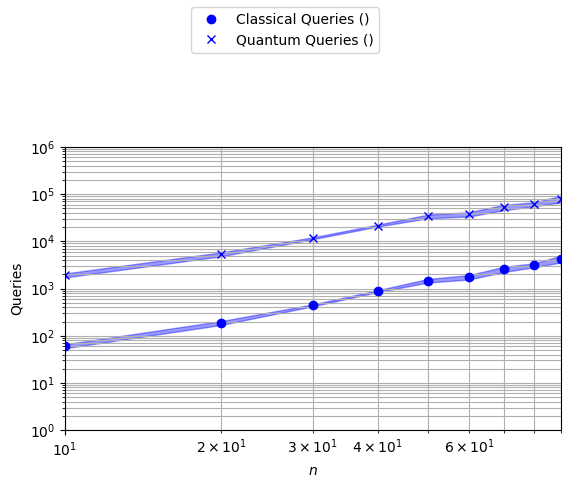

In [ ]:
Plotter().plot(data, quantum_factor=2)

### Benchmarking large instances
We can now benchmark larger instances using the reference implementation and visualize the stats.

In [ ]:
from hillclimber import run

rng = np.random.default_rng(seed=42)
data_ref = pd.concat(
    [run(k=3, n=n, r=3, n_runs=3, rng=rng, error=1e-3) for n in range(50, 700, 50)]
)

In [ ]:
data_ref.columns

Index(['classical_control_method_calls', 'classical_actual_queries',
       'classical_expected_queries', 'quantum_expected_classical_queries',
       'quantum_expected_quantum_queries', 'n', 'k', 'r'],
      dtype='object')

In [ ]:
class FullPlotter(Plotter):
    def compute_aggregates(self, data, *, quantum_factor):
        # compute combined query costs of quantum search
        Q_c = data["quantum_expected_classical_queries"]
        Q_q = data["quantum_expected_quantum_queries"]
        data["C"] = data["classical_actual_queries"]
        data["Q"] = Q_c + quantum_factor * Q_q
        return data

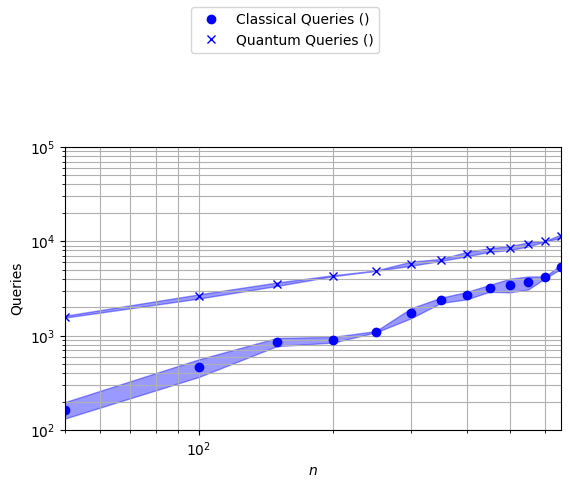

In [ ]:
FullPlotter().plot(data_ref, quantum_factor=2, y_lower_lim=100)

As we can see here, we need less queries for the simple hillclimber for our problem instances. The simple hillclimber also shows more apparent possibilities for performance improvements through quantum algorithms, specifically Grover search in that case. This can be seen even more clearly in the plots provided in this paper on page 28: https://arxiv.org/abs/2203.04975